# **Logistic Regression vs Naive Bayes: A Comparative Study on Banknote Authentication**



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set(style="whitegrid", context="notebook")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
# UCI Banknote Authentication dataset
# Columns: variance, skewness, curtosis, entropy, class
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"

column_names = ["variance", "skewness", "curtosis", "entropy", "class"]
data = pd.read_csv(url, header=None, names=column_names)

print("Shape of dataset:", data.shape)
data.head()

Shape of dataset: (1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variance  1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB
None

Summary statistics:



,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000



Class distribution (0 = genuine, 1 = forged):
class
0    762
1    610
Name: count, dtype: int64


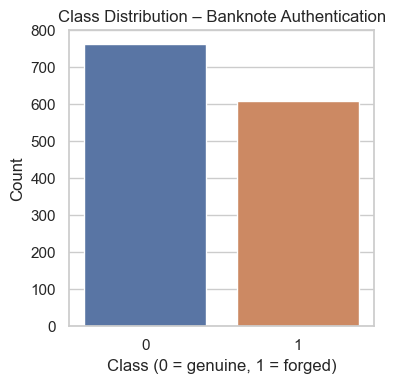

In [3]:
print("Dataset info:\n")
print(data.info())

print("\nSummary statistics:\n")
display(data.describe())

print("\nClass distribution (0 = genuine, 1 = forged):")
print(data["class"].value_counts())

plt.figure(figsize=(4, 4))
sns.countplot(x="class", data=data)
plt.title("Class Distribution – Banknote Authentication")
plt.xlabel("Class (0 = genuine, 1 = forged)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


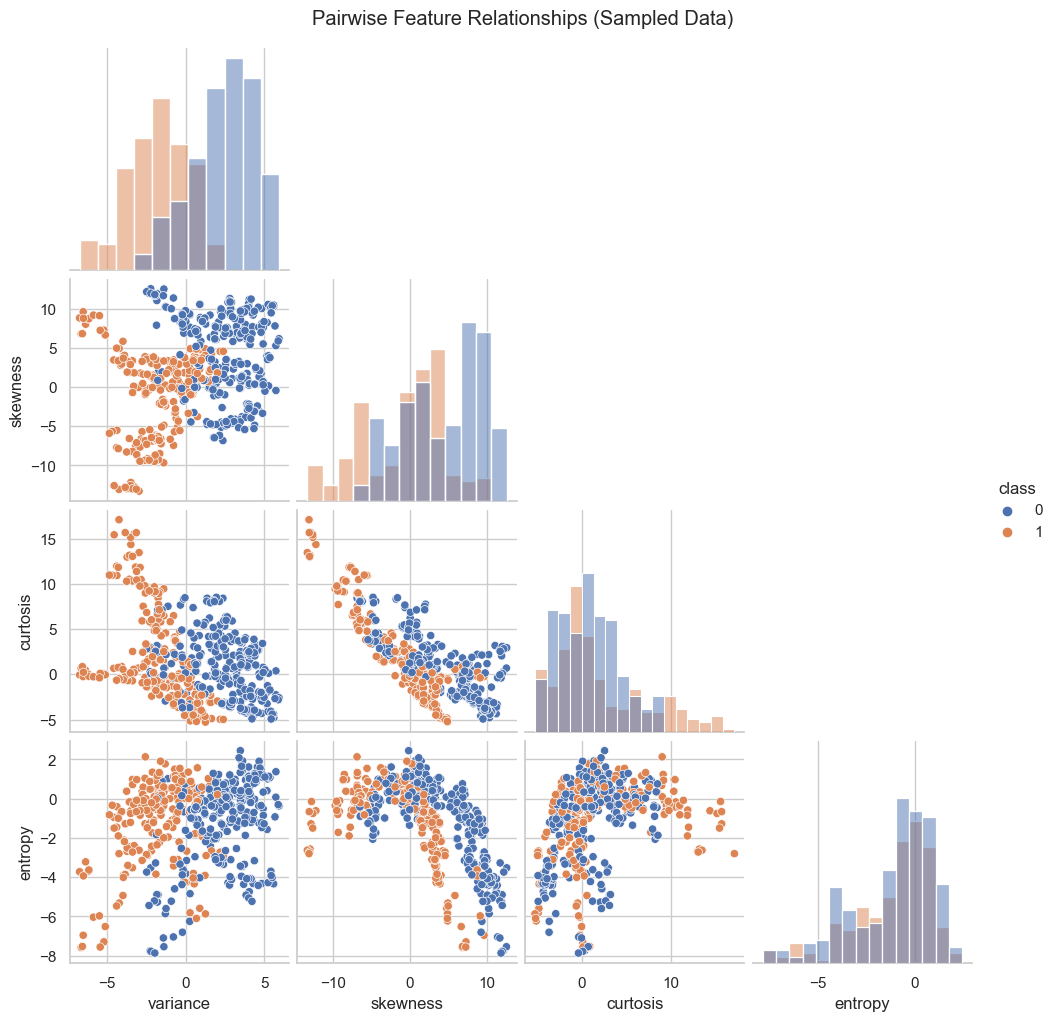

In [4]:
# Pairplot to understand relationships between features and class separation
sns.pairplot(
    data.sample(min(500, len(data)), random_state=RANDOM_STATE),
    vars=["variance", "skewness", "curtosis", "entropy"],
    hue="class",
    diag_kind="hist",
    corner=True
)
plt.suptitle("Pairwise Feature Relationships (Sampled Data)", y=1.02)
plt.show()


In [5]:
X = data.drop(columns=["class"]).values  # 4 features
y = data["class"].values                 # binary labels (0,1)

print("Feature shape:", X.shape)
print("Target distribution:", np.bincount(y))


Feature shape: (1372, 4)
Target distribution: [762 610]


In [6]:
# Train-test split with stratification
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

# Standardise features for Logistic Regression (and for PCA)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

X_train.shape, X_test.shape


((960, 4), (412, 4))

In [7]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)
print("Total variance captured:", pca.explained_variance_ratio_.sum())

# Combine PCA coordinates and labels for plotting
train_pca_df = pd.DataFrame({
    "PC1": X_train_pca[:, 0],
    "PC2": X_train_pca[:, 1],
    "class": y_train
})

train_pca_df.head()


Explained variance ratio (2 components): [0.54453636 0.32217828]
Total variance captured: 0.8667146397527834


,PC1,PC2,class
0,1.134959,-3.905259,1
1,-0.960772,-0.015848,1
2,2.097465,-2.383236,0
3,1.126268,1.347671,0
4,-0.566826,0.572560,0


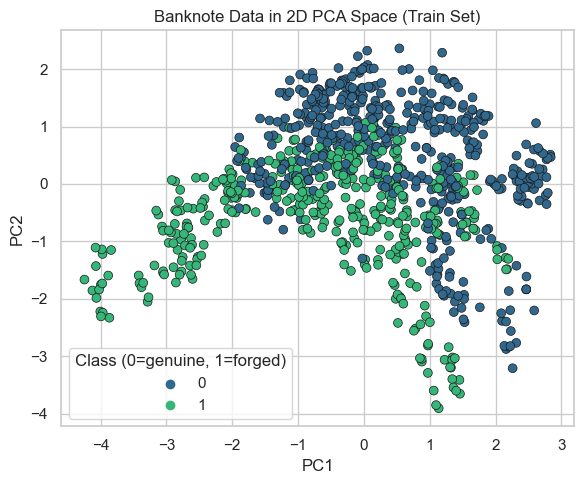

In [8]:
plt.figure(figsize=(6, 5))
sns.scatterplot(
    x="PC1",
    y="PC2",
    hue="class",
    data=train_pca_df,
    palette="viridis",
    s=40,
    edgecolor="k"
)
plt.title("Banknote Data in 2D PCA Space (Train Set)")
plt.legend(title="Class (0=genuine, 1=forged)")
plt.tight_layout()
plt.show()


## Logistic Regression vs Gaussian Naive Bayes – Theory Overview

Before fitting models, it is important to understand what each algorithm *assumes* about the data.

### Logistic Regression

Logistic Regression models the **log-odds** of the positive class as a **linear function of the features**:

$$
\log \frac{P(y=1 \mid x)}{P(y=0 \mid x)} = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p.
$$

Equivalently, the probability of class 1 is:

$$
P(y=1 \mid x) = \sigma(z) = \frac{1}{1 + e^{-z}},
$$

where \( z = \beta_0 + \beta^\top x\) and \(\sigma(\cdot)\) is the **sigmoid function**.

This implies a **linear decision boundary** in feature space.  
In PCA space, the boundary will appear as (roughly) a straight line.

---

### Gaussian Naive Bayes

Gaussian Naive Bayes models the **class-conditional distribution** of features as independent Gaussians:

$$
p(x \mid y = c) = \prod_{j=1}^p \mathcal{N}(x_j \mid \mu_{cj}, \sigma_{cj}^2),
$$

and uses Bayes’ rule to compute posterior probabilities:

$$
P(y=c \mid x) \propto P(y=c)\, p(x \mid y=c).
$$

The crucial assumption is **feature independence given the class**.  
Even when this assumption is not strictly true, Naive Bayes often performs surprisingly well in practice (Murphy, 2012).

The decision boundary can be **non-linear** in the original space due to differences in class variances.


In [9]:
log_reg = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_STATE
)

log_reg.fit(X_train, y_train)

y_pred_log = log_reg.predict(X_test)
y_proba_log = log_reg.predict_proba(X_test)[:, 1]

acc_log = accuracy_score(y_test, y_pred_log)
print(f"Logistic Regression – Test Accuracy: {acc_log:.4f}")

print("\nClassification Report – Logistic Regression:")
print(classification_report(y_test, y_pred_log, digits=4))


Logistic Regression – Test Accuracy: 0.9782

Classification Report – Logistic Regression:
              precision    recall  f1-score   support

           0     1.0000    0.9607    0.9800       229
           1     0.9531    1.0000    0.9760       183

    accuracy                         0.9782       412
   macro avg     0.9766    0.9803    0.9780       412
weighted avg     0.9792    0.9782    0.9782       412



In [10]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

y_pred_nb = nb_clf.predict(X_test)
y_proba_nb = nb_clf.predict_proba(X_test)[:, 1]

acc_nb = accuracy_score(y_test, y_pred_nb)
print(f"Gaussian Naive Bayes – Test Accuracy: {acc_nb:.4f}")

print("\nClassification Report – Gaussian Naive Bayes:")
print(classification_report(y_test, y_pred_nb, digits=4))


Gaussian Naive Bayes – Test Accuracy: 0.8641

Classification Report – Gaussian Naive Bayes:
              precision    recall  f1-score   support

           0     0.8712    0.8865    0.8788       229
           1     0.8547    0.8361    0.8453       183

    accuracy                         0.8641       412
   macro avg     0.8630    0.8613    0.8620       412
weighted avg     0.8639    0.8641    0.8639       412



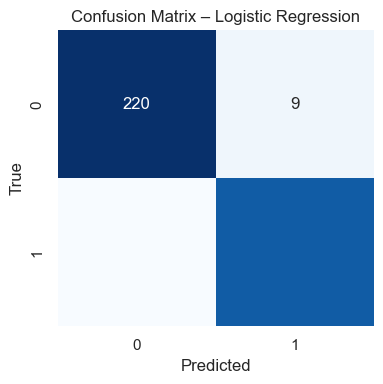

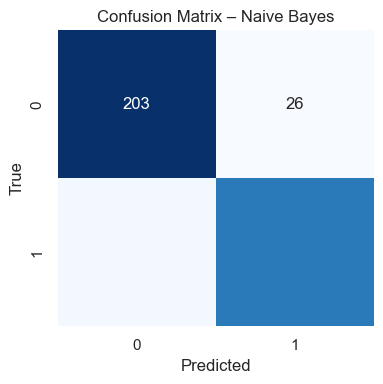

In [11]:
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=labels,
        yticklabels=labels,
        cbar=False
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

cm_log = confusion_matrix(y_test, y_pred_log)
cm_nb = confusion_matrix(y_test, y_pred_nb)

plot_confusion_matrix(cm_log, labels=[0, 1], title="Confusion Matrix – Logistic Regression")
plot_confusion_matrix(cm_nb, labels=[0, 1], title="Confusion Matrix – Naive Bayes")


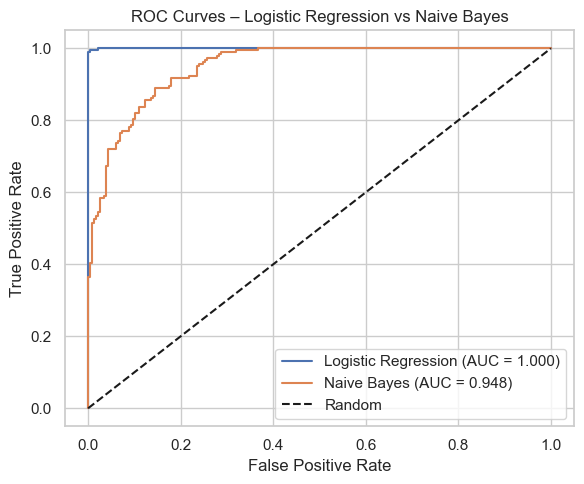

In [12]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
roc_auc_log = auc(fpr_log, tpr_log)

fpr_nb, tpr_nb, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

plt.figure(figsize=(6, 5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {roc_auc_log:.3f})")
plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {roc_auc_nb:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – Logistic Regression vs Naive Bayes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [13]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary_2d(model, X, y, title, h=0.02):
    """
    Plot decision boundary for a 2D feature space.
    X : np.array of shape (n_samples, 2)
    y : labels (0/1)
    """
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )

    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    cmap_light = ListedColormap(["#FFBBBB", "#BBFFBB"])
    cmap_bold = ["#FF0000", "#00AA00"]

    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap_light)

    for idx, cls in enumerate(np.unique(y)):
        plt.scatter(
            X[y == cls, 0],
            X[y == cls, 1],
            c=cmap_bold[idx],
            label=f"Class {cls}",
            edgecolor="k",
            s=40
        )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [14]:
# For geometric visualisation, fit models on 2D PCA features
log_reg_pca = LogisticRegression(
    solver="lbfgs",
    max_iter=1000,
    random_state=RANDOM_STATE
)
log_reg_pca.fit(X_train_pca, y_train)

nb_pca = GaussianNB()
nb_pca.fit(X_train_pca, y_train)

# Evaluate quickly to ensure they behave reasonably
y_pred_log_pca = log_reg_pca.predict(X_test_pca)
y_pred_nb_pca = nb_pca.predict(X_test_pca)

print("Logistic Regression (PCA) Accuracy:", accuracy_score(y_test, y_pred_log_pca))
print("Naive Bayes (PCA) Accuracy:", accuracy_score(y_test, y_pred_nb_pca))


Logistic Regression (PCA) Accuracy: 0.7864077669902912
Naive Bayes (PCA) Accuracy: 0.7742718446601942


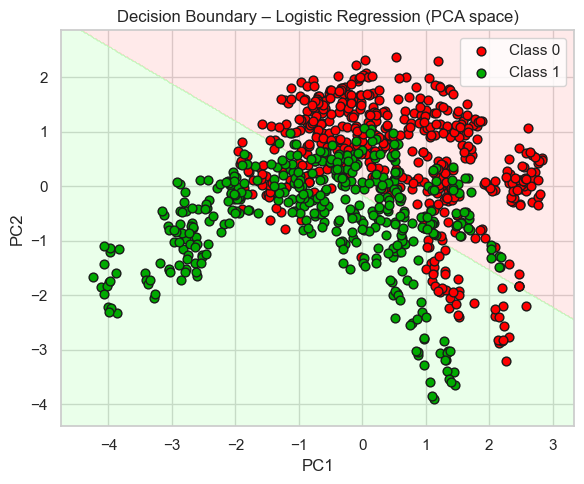

In [15]:
plot_decision_boundary_2d(
    log_reg_pca,
    X_train_pca,
    y_train,
    title="Decision Boundary – Logistic Regression (PCA space)"
)


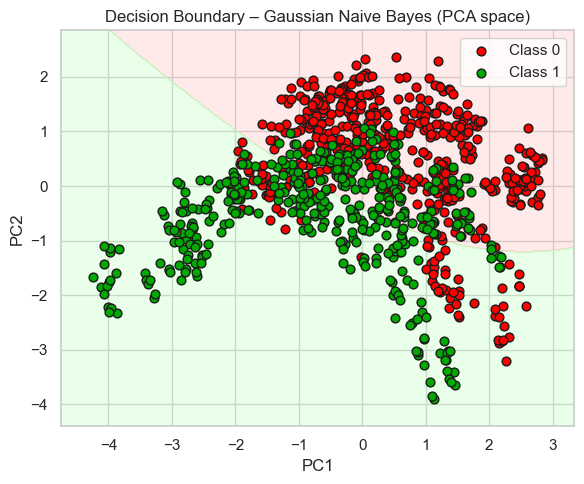

In [16]:
plot_decision_boundary_2d(
    nb_pca,
    X_train_pca,
    y_train,
    title="Decision Boundary – Gaussian Naive Bayes (PCA space)"
)


## Summary of Findings

- Both **Logistic Regression** and **Gaussian Naive Bayes** achieve high accuracy  
  on the Banknote Authentication dataset, which is highly separable after scaling.

- Logistic Regression assumes a **linear relationship** in log-odds space and,  
  as expected, produces a mostly **linear decision boundary** in PCA space.

- Gaussian Naive Bayes assumes **independent Gaussian features per class**.  
  Even though the independence assumption is not perfectly satisfied, its decision  
  boundary remains competitive and sometimes slightly more flexible due to class-conditional variances.

- ROC curves show that **both models achieve strong AUC** values, confirming that  
  they are able to rank genuine and forged notes reliably.

These experiments highlight that even very simple models can be highly effective when  
the dataset has a clear underlying structure.
